### Analysis software development 

Goal: establish smooth reading of the binary DAQ datafiles

In [1]:
import sys
sys.path.insert(0,'python/')
import struct
import matplotlib.pyplot as plt
import numpy as np
# import data handling class
from DT5550 import DT5550

Filename to process

In [6]:
filename = '../daq/ReadoutClient/test_new.data'

Open a datafile and read the data

In [7]:
#
# open the datfile
#
print('Open datafile:',filename)
io = DT5550(file=filename)
#
# loop over the data
#
while(io.read_event() == 0):
    if io.n_event%5000 == 0:
        print('Processed ',io.n_event,' events')
    # here you can decide what to do with the event information
    # ......
print('Processing done')

Open datafile: ../daq/ReadoutClient/test_new.data
Processed  5000  events
Processed  10000  events
Processing done


A few basic plots: integrated charge and time

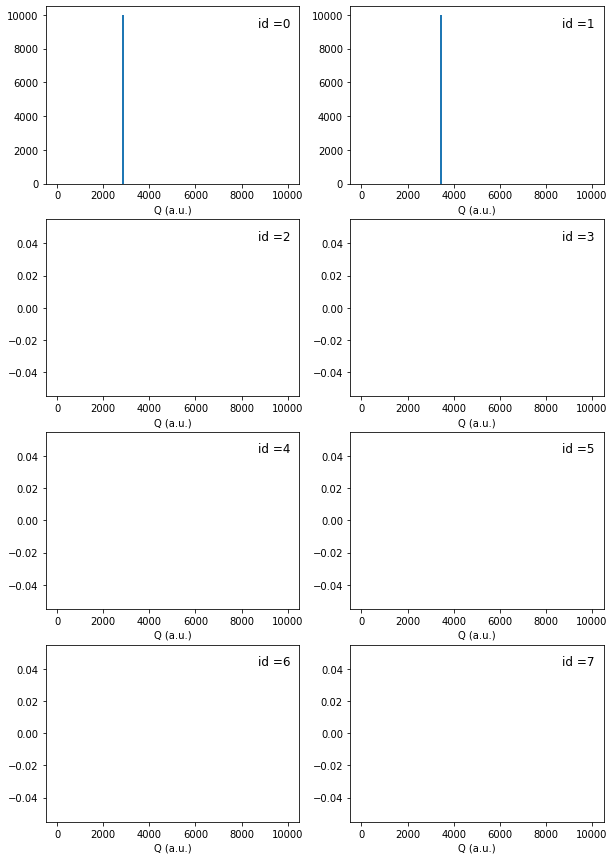

In [8]:
io.plot_all(type="charge",range=(0,10000))

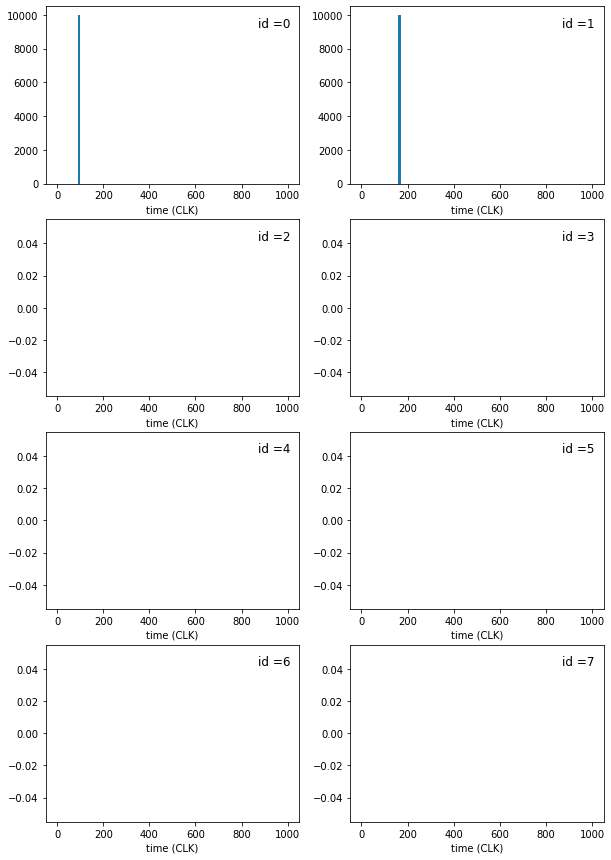

In [9]:
io.plot_all(type="time",range=(0,1000))